In [1]:
import rioxarray
import numpy as np
from pathlib import Path
import os
import sys
project_path = os.path.abspath(os.path.join('..', '..'))
if project_path not in sys.path:
    sys.path.insert(0, project_path)

from source.config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC

In [2]:
import urllib
import rioxarray
import numpy as np
from pathlib import Path

for year in np.arange(2000,2021):
    for s in ["m","f"]:
        for age in [0,65,70,75,80]:
            downoald_url =  f"https://data.worldpop.org/GIS/AgeSex_structures/Global_2000_2020/{year}/0_Mosaicked/global_mosaic_1km/global_{s}_{age}_{year}_1km.tif"
            filepath = DATA_SRC / f"worldpop/global_{s}_{age}_{year}_1km.tif"
            if not Path(filepath).is_file():      
                urllib.request.urlretrieve(downoald_url, filepath)
    download_url = f"https://data.worldpop.org/GIS/Population/Global_2000_2020/{year}/0_Mosaicked/ppp_{year}_1km_Aggregated.tif"
    filepath = DATA_SRC / f"worldpop/ppp_{year}_1km_Aggregated.tif"
    if not Path(filepath).is_file():      
        urllib.request.urlretrieve(downoald_url, filepath)

In [3]:
def clean_and_coarsen(data_array):
    """
    Cleans the data to get read of negative, infinite and nan values, as well as coarsens by suming

    Parameters:
    data_array (xarray.DataArray): The data array to be cleaned.

    Returns:
    xarray.DataArray: The cleaned data array.
    """
    data_array = data_array.where(data_array > 0, 0)
    data_array = data_array.where(data_array < 3.1e8, 0)
    data_array = data_array.where(data_array != -np.inf, 0)
    data_array = data_array.where(data_array != np.inf, 0)
    data_array = data_array.fillna(0)
    data_array = data_array.rename({'y': 'latitude', 'x': 'longitude'})
    print(data_array.latitude)
    data_array = data_array.coarsen(latitude=10).sum()
    data_array = data_array.coarsen(longitude=20).sum()
    print(data_array.latitude)

    data_array = data_array.fillna(0)

    return data_array

import os
import rioxarray
import numpy as np

def sum_files(files, directory=""): 
    """
    Sums data across a list of files. The summing is useful for the age over 65, 
    made out of several age categories

    Parameters:
    files (list): A list of file paths to process.
    directory (str, optional): The directory path if it's not included in the file paths.

    Returns:
    xarray.DataArray: An array containing the summed data across the specified files.
    """
    total_sum = None
    for file in files:
        data_array = rioxarray.open_rasterio(os.path.join(directory, file))

        if total_sum is None:
            total_sum = data_array
        else:
            total_sum += data_array

    return total_sum

In [4]:
import xarray as xr
from shapely.geometry import Point
import geopandas as gpd

# open on year of era5 to put population data on the same grid
era5_data = xr.open_dataset(WEATHER_SRC / "era5_0.25deg/daily_temperature_summary/1980_temperature_summary.nc")
era5_data = era5_data.assign_coords(longitude=(((era5_data.longitude + 180) % 360) - 180))
era5_grid = era5_data.isel(time=0).to_dataframe().reset_index()
era5_grid['geometry'] = era5_grid.apply(lambda row: Point(row.longitude, row.latitude), axis=1)
era5_grid = gpd.GeoDataFrame(era5_grid, geometry='geometry')
era5_grid.set_crs('EPSG:4326', inplace=True)
era5_grid = era5_grid[['longitude','latitude', 'geometry']]
era5_grid_3395 = era5_grid.to_crs('EPSG:3395')


In [7]:
from pathlib import Path

def process_and_combine_ages(ages, sex, start_year, directory, era5_grid, mapping=None):
    combined_files = []
    for age in ages:
        age_files = [f for f in os.listdir(directory) if f'_{sex}_{age}_{start_year}' in f and f.endswith('.tif')]
        combined_files.extend(age_files)
    # Use sum_files to sum the data from the combined files
    summed_data = sum_files(combined_files, directory)

    # Clean and coarsen the summed data
    cleaned_and_coarsened_data = clean_and_coarsen(summed_data)
    pop = cleaned_and_coarsened_data.to_dataframe('pop').reset_index()
    print(pop['pop'].sum())

    pop['geometry'] = pop.apply(lambda row: Point(row.longitude, row.latitude), axis=1)
    pop = gpd.GeoDataFrame(pop, geometry='geometry')
    pop.set_crs('EPSG:4326', inplace=True)
    pop = pop.to_crs('EPSG:3395')

    pop = pop[pop['pop']>0]
    pop_era5_grid = gpd.sjoin_nearest(pop, era5_grid, how='inner')

    pop_regrided = pop_era5_grid.groupby(['longitude_right','latitude_right']).sum().reset_index()[['longitude_right','latitude_right','pop']]
    #pop_regrided['geometry'] = pop_regrided.apply(lambda row: Point(row.longitude_right, row.latitude_right), axis=1)
    #pop_regrided = gpd.GeoDataFrame(pop_regrided, geometry='geometry')

    return pop_regrided

worldpop_dir = DATA_SRC / "worldpop/"
ages = ['0']
for start_year in np.arange(2000, 2020):
    for sex in ["f"]:
        #remapped_data, era5_grid_mapping = process_and_combine_ages([65, 70, 75, 80], sex, start_year, worldpop_dir, era5_data, era5_grid_mapping)
        pop_regrided = process_and_combine_ages([0], sex, start_year, worldpop_dir, era5_grid_3395)
        pop_regrided = pop_regrided.rename(columns={"latitude_right":"latitude","longitude_right":"longitude"})
        pop_regrided = era5_grid.merge(pop_regrided[['longitude','latitude', 'pop']], how='left')
        pivoted_df = pop_regrided.pivot(index='latitude', columns='longitude', values='pop')

        # Convert the pivoted DataFrame to an xarray DataArray
        da = xr.DataArray(pivoted_df, dims=['latitude', 'longitude'])

        # Optionally, add the time coordinate (if you have multiple time points, this step will differ)
        da = da.expand_dims(time=[start_year])

        # Convert to Dataset if you want to add more variables or simply prefer a Dataset structure
        pop_resampled = da.to_dataset(name='pop')
        pop_resampled['longitude'] = xr.where(pop_resampled['longitude'] < 0, pop_resampled['longitude'] + 360, pop_resampled['longitude'])
        pop_resampled = pop_resampled.sortby('longitude')
        out_path = Path('/nfs/n2o/wcr/szelie/worldpop/') / 'era5_compatible2' / f'{sex}_{"_".join(map(str, ages))}_{start_year}_era5_compatible.nc'

        pop_resampled.to_netcdf(out_path)

<xarray.DataArray 'latitude' (latitude: 18720)>
array([ 83.995417,  83.987083,  83.97875 , ..., -71.979583, -71.987916,
       -71.99625 ])
Coordinates:
  * latitude     (latitude) float64 84.0 83.99 83.98 ... -71.98 -71.99 -72.0
    spatial_ref  int64 0
<xarray.DataArray 'latitude' (latitude: 1872)>
array([ 83.957917,  83.874583,  83.79125 , ..., -71.792083, -71.875416,
       -71.95875 ])
Coordinates:
  * latitude     (latitude) float64 83.96 83.87 83.79 ... -71.79 -71.88 -71.96
    spatial_ref  int64 0
66902228.0


In [11]:
from pathlib import Path

def process_and_combine_ages(ages, sex, start_year, directory, era5_grid):
    combined_files = []
    for age in ages:
        age_files = [f for f in os.listdir(directory) if f'_{sex}_{age}_{start_year}' in f and f.endswith('.tif')]
        combined_files.extend(age_files)
    # Use sum_files to sum the data from the combined files
    summed_data = sum_files(combined_files, directory)

    # Clean and coarsen the summed data
    cleaned_and_coarsened_data = clean_and_coarsen(summed_data)
    pop = cleaned_and_coarsened_data.to_dataframe('pop').reset_index()
    print(pop['pop'].sum())

    pop['geometry'] = pop.apply(lambda row: Point(row.longitude, row.latitude), axis=1)
    pop = gpd.GeoDataFrame(pop, geometry='geometry')
    pop.set_crs('EPSG:4326', inplace=True)
    pop = pop.to_crs('EPSG:3395')

    pop = pop[pop['pop']>0]
    pop_era5_grid = gpd.sjoin_nearest(pop, era5_grid, how='left')
    print(pop_era5_grid['pop'].sum())

    pop_regrided = pop_era5_grid.groupby(['longitude_right','latitude_right']).sum().reset_index()[['longitude_right','latitude_right','pop']]
    #pop_regrided['geometry'] = pop_regrided.apply(lambda row: Point(row.longitude_right, row.latitude_right), axis=1)
    #pop_regrided = gpd.GeoDataFrame(pop_regrided, geometry='geometry')

    return pop_regrided

worldpop_dir = DATA_SRC / "worldpop/"
ages = [65, 70, 75, 80]
for start_year in np.arange(2014, 2020):
    for sex in ["f","m"]:
        #remapped_data, era5_grid_mapping = process_and_combine_ages([65, 70, 75, 80], sex, start_year, worldpop_dir, era5_data, era5_grid_mapping)
        pop_regrided = process_and_combine_ages(ages, sex, start_year, worldpop_dir, era5_grid_3395)
        pop_regrided = pop_regrided.rename(columns={"latitude_right":"latitude","longitude_right":"longitude"})
        pop_regrided = era5_grid.merge(pop_regrided[['longitude','latitude', 'pop']], how='left')
        pivoted_df = pop_regrided.pivot(index='latitude', columns='longitude', values='pop')

        # Convert the pivoted DataFrame to an xarray DataArray
        da = xr.DataArray(pivoted_df, dims=['latitude', 'longitude'])

        # Optionally, add the time coordinate (if you have multiple time points, this step will differ)
        da = da.expand_dims(time=[start_year])

        # Convert to Dataset if you want to add more variables or simply prefer a Dataset structure
        pop_resampled = da.to_dataset(name='pop')
        pop_resampled['longitude'] = xr.where(pop_resampled['longitude'] < 0, pop_resampled['longitude'] + 360, pop_resampled['longitude'])
        pop_resampled = pop_resampled.sortby('longitude')
        out_path = Path('/nfs/n2o/wcr/szelie/worldpop/') / 'era5_compatible2' / f'{sex}_{"_".join(map(str, ages))}_{start_year}_era5_compatible.nc'

        pop_resampled.to_netcdf(out_path)

<xarray.DataArray 'latitude' (latitude: 18720)>
array([ 83.995417,  83.987083,  83.97875 , ..., -71.979583, -71.987916,
       -71.99625 ])
Coordinates:
  * latitude     (latitude) float64 84.0 83.99 83.98 ... -71.98 -71.99 -72.0
    spatial_ref  int64 0
<xarray.DataArray 'latitude' (latitude: 1872)>
array([ 83.957917,  83.874583,  83.79125 , ..., -71.792083, -71.875416,
       -71.95875 ])
Coordinates:
  * latitude     (latitude) float64 83.96 83.87 83.79 ... -71.79 -71.88 -71.96
    spatial_ref  int64 0
326521020.0
326521000.0
<xarray.DataArray 'latitude' (latitude: 18720)>
array([ 83.995417,  83.987083,  83.97875 , ..., -71.979583, -71.987916,
       -71.99625 ])
Coordinates:
  * latitude     (latitude) float64 84.0 83.99 83.98 ... -71.98 -71.99 -72.0
    spatial_ref  int64 0
<xarray.DataArray 'latitude' (latitude: 1872)>
array([ 83.957917,  83.874583,  83.79125 , ..., -71.792083, -71.875416,
       -71.95875 ])
Coordinates:
  * latitude     (latitude) float64 83.96 83.87 83.79 ... 

In [40]:
#data = xr.open_dataset('/nfs/n2o/wcr/szelie/worldpop/era5_compatible2/m_65_70_75_80_2019_era5_compatible.nc')pop_regrided = pop_regrided.rename(columns={"latitude_right":"latitude","longitude_right":"longitude"})
#pop_regrided = era5_grid.merge(pop_regrided[['longitude','latitude', 'pop']], how='left')
pivoted_df = pop_regrided.pivot(index='latitude', columns='longitude', values='pop')

# Convert the pivoted DataFrame to an xarray DataArray
da = xr.DataArray(pivoted_df, dims=['latitude', 'longitude'])

# Optionally, add the time coordinate (if you have multiple time points, this step will differ)
da = da.expand_dims(time=[start_year])

# Convert to Dataset if you want to add more variables or simply prefer a Dataset structure
pop_resampled = da.to_dataset(name='pop')
pop_resampled['longitude'] = xr.where(pop_resampled['longitude'] < 0, pop_resampled['longitude'] + 360, pop_resampled['longitude'])
pop_resampled = pop_resampled.sortby('longitude')

In [2]:
import xarray as xr
import numpy as np
from pathlib import Path
# Function to load population data for a specific demographic group (infants or elderly)
def load_population_data(group, gender, years, suffix):
    return {year: xr.open_dataset(DATA_SRC / 'worldpop/era5_compatible2' / f"{gender}_{group}_{str(year)}_{suffix}") for year in years}

# Function to sum male and female datasets and rename 'time' dimension to 'year'
def combine_and_rename(data_m, data_f):
    combined_data = {year: data_f[year] + data_m[year] for year in data_m}
    for year in combined_data:
        combined_data[year] = combined_data[year].rename({'time':'year'})
    return xr.concat(combined_data.values(), dim='year')

def concatenate_and_extrapolate(old_data, new_data):
    combined_data = xr.concat([old_data, new_data], dim='year')
    return xr.concat([combined_data, combined_data.interp(year=extrapolated_years, kwargs={"fill_value": "extrapolate"})], 'year').load()


# Load and combine infant and elderly population data for 2000-2020
years_range = np.arange(2000, 2020)
infants_m = load_population_data("0", "m", years_range, "era5_compatible.nc")
infants_f = load_population_data("0", "f", years_range, "era5_compatible.nc")
elderly_m = load_population_data("65_70_75_80", "m", years_range, "era5_compatible.nc")
elderly_f = load_population_data("65_70_75_80", "f", years_range, "era5_compatible.nc")

# Combine and process data for both infants and elderly
infants_worldpop_2000_2020 = combine_and_rename(infants_m, infants_f)
elderly_worldpop_2000_2020 = combine_and_rename(elderly_m, elderly_f)

# Load additional population data for 1950-1999
infants_totals_file = POP_DATA_SRC / 'hybrid_2023' / 'infants_1950_2020_hybrid_15_min_era_compat.nc' # files generated for lancet report 2023
population_infants_1950_1999 = xr.open_dataarray(infants_totals_file).sel(year=slice(1950, 1999))

demographics_totals_file = POP_DATA_SRC / 'hybrid_2023' / 'demographics_hybrid_1950_2020_15_min_era_compat.nc'
demographics_totals = xr.open_dataarray(demographics_totals_file)
elderly_1950_1999 = demographics_totals.sel(age_band_lower_bound=65).sel(year=slice(1950,1999))

# Combine data for all years (1950-2020) and extrapolate to 2023
MAX_YEAR = 2023
extrapolated_years = np.arange(2020, MAX_YEAR + 1)
infants_worldpop_2000_2020 = infants_worldpop_2000_2020.rename({'pop':'infants'})
population_infants_worldpop = concatenate_and_extrapolate(population_infants_1950_1999.to_dataset(), infants_worldpop_2000_2020)
population_infants_worldpop = population_infants_worldpop.transpose("year", "latitude", "longitude")


elderly_1950_1999 = elderly_1950_1999.to_dataset().rename({'demographic_totals':'elderly'})
elderly_worldpop_2000_2020 = elderly_worldpop_2000_2020.rename({'pop':'elderly'})

population_elderly_worldpop = concatenate_and_extrapolate(elderly_1950_1999, elderly_worldpop_2000_2020)
population_elderly_worldpop = population_elderly_worldpop.transpose("year", "latitude", "longitude")
# # Save the results to NetCDF files
population_infants_worldpop.to_netcdf(POP_DATA_SRC / 'hybrid_2024' / f'worldpop_infants_1950_{MAX_YEAR}_era5_compatible.nc')
population_elderly_worldpop.to_netcdf(POP_DATA_SRC / 'hybrid_2024' / f'worldpop_elderly_1950_{MAX_YEAR}_era5_compatible.nc')


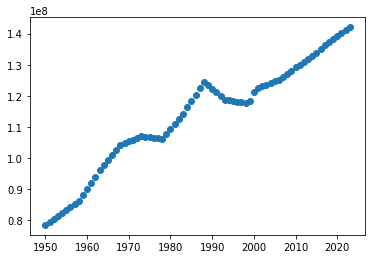

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plot_data = population_infants_worldpop.sum(dim=['latitude','longitude'])
ax.scatter(plot_data.year, plot_data.infants)

